In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from pathlib import Path
import requests

## device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, accuracy_fn, plot_decision_boundary


helper_functions.py already exists


## create and visualize data

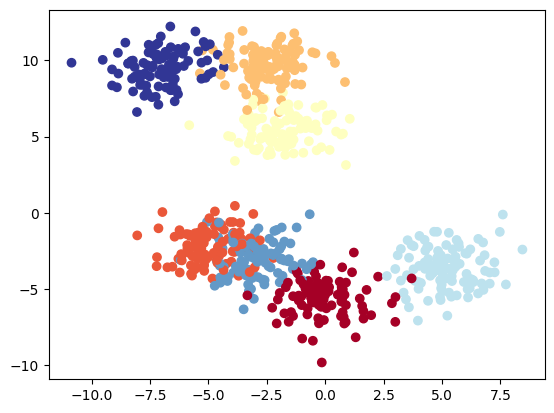

In [4]:
X_blob, y_blob = make_blobs(
                            n_samples=700,
                            n_features=2,
                            centers=7,
                            cluster_std=1.15,
                            center_box=(-10.0, 10.0),
                            shuffle=True,
                            random_state=50,
                            return_centers=False
                            )
plt.scatter(
          x=X_blob[:, 0],
          y=X_blob[:, 1],
          c=y_blob,
          cmap=plt.cm.RdYlBu
          );

## check data type

In [5]:
type(X_blob)

numpy.ndarray

## convert from nd.array to torch.tensor

In [6]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [7]:
type(X_blob)

torch.Tensor

## create train/test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                  X_blob,
                  y_blob,
                  train_size=0.8,
                  random_state=50
                  )

## create model for data analysis

In [9]:
class BlobModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=64),
        nn.Linear(in_features=64, out_features=64),
        nn.Linear(in_features=64, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_1 = BlobModelV1(2, 7).to(device)
model_1_str = str(model_1)
clean_model_str = model_1_str.replace("(", " ").replace(")", " ")

## define loss function and optimizer

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)
optimizer_class_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]["lr"]

## write training and test loop

In [11]:
torch.manual_seed(50)
torch.cuda.manual_seed(50)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

epochs = 1050

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train)

  y_pred = torch.argmax(y_logits, dim=1)
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)

    test_pred = torch.argmax(test_logits, dim=1)
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 50 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      acc_values.append(acc)
      test_loss_values.append(test_loss)
      test_acc_values.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 2.02258 | Acc: 13.39 | Test Loss: 1.56749 | Test Acc: 44.29
Epoch: 50 | Loss: 0.61296 | Acc: 73.75 | Test Loss: 0.62798 | Test Acc: 76.43
Epoch: 100 | Loss: 0.52101 | Acc: 78.93 | Test Loss: 0.54469 | Test Acc: 82.14
Epoch: 150 | Loss: 0.47465 | Acc: 80.71 | Test Loss: 0.50431 | Test Acc: 85.00
Epoch: 200 | Loss: 0.44315 | Acc: 82.50 | Test Loss: 0.47827 | Test Acc: 85.71
Epoch: 250 | Loss: 0.41855 | Acc: 83.04 | Test Loss: 0.45888 | Test Acc: 85.71
Epoch: 300 | Loss: 0.39772 | Acc: 84.82 | Test Loss: 0.44300 | Test Acc: 85.71
Epoch: 350 | Loss: 0.37918 | Acc: 86.61 | Test Loss: 0.42916 | Test Acc: 85.00
Epoch: 400 | Loss: 0.36220 | Acc: 88.21 | Test Loss: 0.41658 | Test Acc: 86.43
Epoch: 450 | Loss: 0.34641 | Acc: 88.75 | Test Loss: 0.40489 | Test Acc: 87.14
Epoch: 500 | Loss: 0.33169 | Acc: 89.64 | Test Loss: 0.39391 | Test Acc: 87.14
Epoch: 550 | Loss: 0.31800 | Acc: 89.82 | Test Loss: 0.38359 | Test Acc: 87.86
Epoch: 600 | Loss: 0.30536 | Acc: 90.00 | Test Loss: 0.

## plot training | test | accuracy over epochs

None


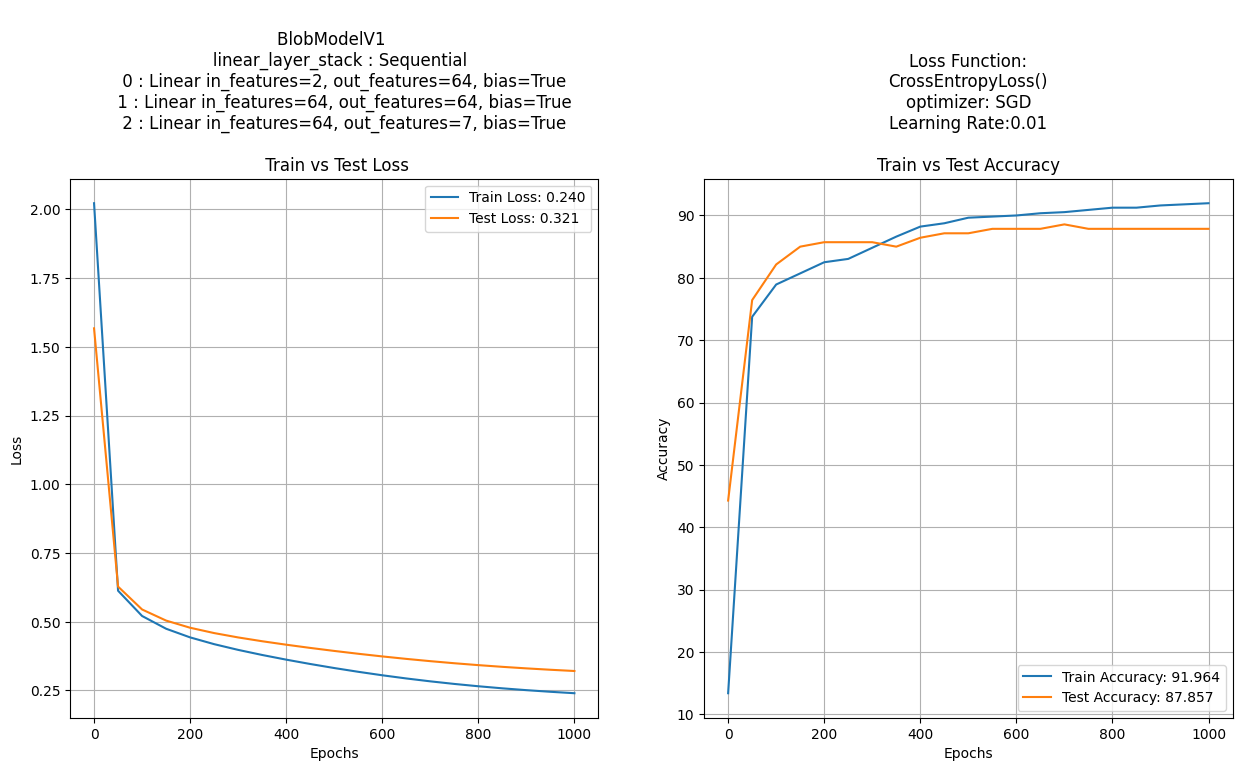

In [12]:
def get_final_values(loss_values, test_loss_values, acc_values, test_acc_values):
    final_loss_val = loss_values[-1]
    final_test_loss_val = test_loss_values[-1]
    final_acc_val = acc_values[-1]
    final_test_acc_val = test_acc_values[-1]
    return final_loss_val, final_test_loss_val, final_acc_val, final_test_acc_val
final_loss, final_test_loss, final_acc, final_test_acc = get_final_values(loss_values, test_loss_values, acc_values, test_acc_values)

def plot_graphs(epochs__count, loss__values, test__loss_values, acc__values, test__acc_values, loss__fn, optimizer__class_name, learning__rate):  
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(epochs__count, np.array(torch.tensor(loss__values).numpy()), label=f"Train Loss: {final_loss:.3f}")
    plt.plot(epochs__count, np.array(torch.tensor(test__loss_values).numpy()), label=f"Test Loss: {final_test_loss:.3f}")
    plt.title(f"\n{clean_model_str}Train vs Test Loss")
    plt.xlabel(f"Epochs")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(epochs__count, np.array(torch.tensor(acc__values).numpy()), label=f"Train Accuracy: {final_acc:.3f}")
    plt.plot(epochs__count, np.array(torch.tensor(test__acc_values).numpy()), label=f"Test Accuracy: {final_test_acc:.3f}")
    plt.title(f"Loss Function:\n{loss__fn}\noptimizer: {optimizer__class_name}\nLearning Rate:{learning__rate}\n\nTrain vs Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend();
print(plot_graphs(epochs_count, loss_values, test_loss_values, acc_values, test_acc_values, loss_fn, optimizer_class_name, learning_rate))


## plot result 

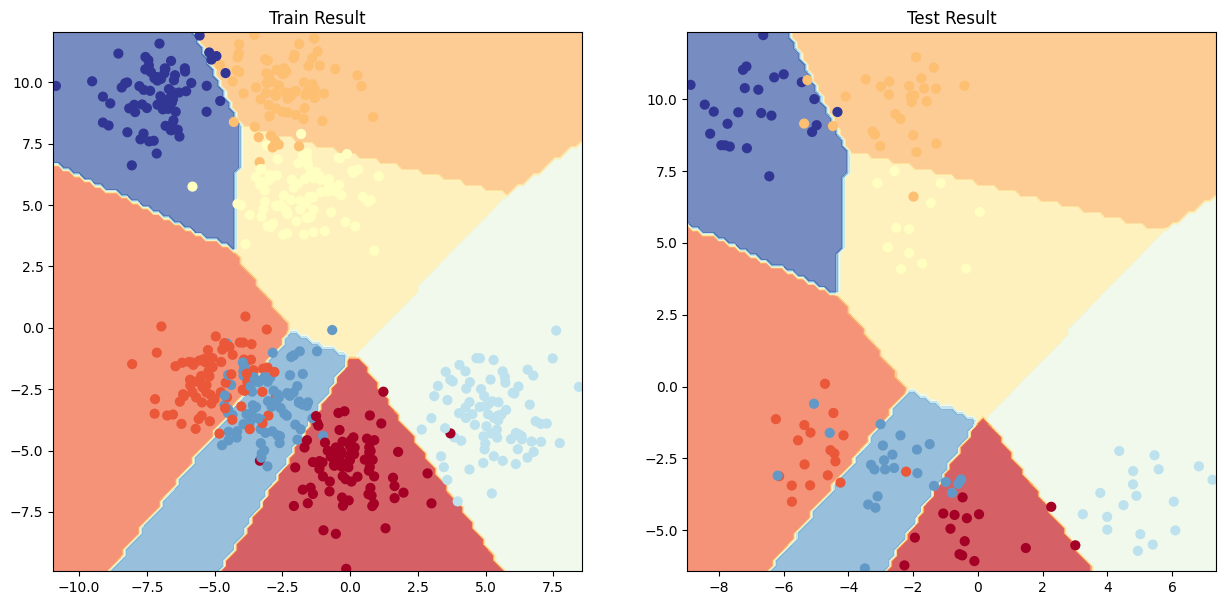

In [13]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Train Result")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Result")
plot_decision_boundary(model_1, X_test, y_test)